Introduction
In this project, we analyze player-tracking data from the NFL Big Data Bowl 2026 competition. Our goal is to understand player behavior during passing plays and build models capable of forecasting the targeted receiver’s movement over the next several frames.
This exploration will be to understand the folowing
* Understand how succesful routes are run.
* Understand if routes are affected by players traits.


We combine exploratory data analysis, statistical hypothesis testing, and multiple predictive models ranging from simple linear regression to LSTMs and kinematic baselines.

Our goal for this project will be to determine if we can predict how a route ends based on the beginning of the route as well as the characteristics of the plaeyr running the route, and see if our ability to do this differs from when we just know the beginning of the route. This will let us do the following 
1) Be able to recognize how routes will end based on the beginning movement. 
2) Be able to recognize how initially similar routes differ from player to player 

In [448]:
import glob
import os
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import ttest_1samp

from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [406]:
# Path to your training folder
base_path = "nfl-big-data-bowl-2026-prediction/train/"

# Get all input and output file paths
input_files = sorted(glob.glob(os.path.join(base_path, "input*.csv")))
output_files = sorted(glob.glob(os.path.join(base_path, "output*.csv")))

print(f"Found {len(input_files)} input files and {len(output_files)} output files")

Found 18 input files and 18 output files


In [407]:

# Read all input and output files
input_files = glob.glob("nfl-big-data-bowl-2026-prediction/train/input*.csv")
output_files = glob.glob("nfl-big-data-bowl-2026-prediction/train/output*.csv")

# Combine all input files
input_df = pd.concat([pd.read_csv(f) for f in input_files], ignore_index=True)

# Combine all output files
output_df = pd.concat([pd.read_csv(f) for f in output_files], ignore_index=True)


In [408]:
# we will normalize the fields so they all go leftward 

FIELD_LENGTH = 120.0
FIELD_WIDTH = 53.3

def turn_all_to_left(df):
    right = df['play_direction'].eq('right')
    # positions
    if 'x' in df.columns: df.loc[right, 'x'] = FIELD_LENGTH - df.loc[right, 'x']
    if 'y' in df.columns: df.loc[right, 'y'] = FIELD_WIDTH  - df.loc[right, 'y']
   
    # angles in degrees
    for col in ('dir','o'):
        if col in df.columns:
            df.loc[right, col] = (df.loc[right, col] + 180.0) % 360.0
    # ball landing
    if 'ball_land_x' in df.columns:
        df.loc[right, 'ball_land_x'] = FIELD_LENGTH - df.loc[right, 'ball_land_x']
    if 'ball_land_y' in df.columns:
        df.loc[right, 'ball_land_y'] = FIELD_WIDTH  - df.loc[right, 'ball_land_y']
    return df


# unify all plays so they move leftward

input_df = turn_all_to_left(input_df)


In [409]:
# One-hot encode the 'player_role' categorical column and play_direction
input_df = pd.get_dummies(input_df, columns=["play_direction"])
input_df = pd.get_dummies(input_df, columns=["player_role"])


In [410]:
def height_to_inches(h):
    if isinstance(h, str) and "-" in h:
        feet, inches = h.split("-")
        return int(feet) * 12 + int(inches)
    return None 

input_df["player_height"] = input_df["player_height"].apply(height_to_inches)


In [411]:
#figure out how to encode player names
input_df['player_name'].nunique()
# I want to end up being able to predict play position using a neural network so might want to use an embedding, but for now will use ID.
# Do not want to use one hot as there are 1400 players in the data set

input_df["player_name"] = input_df["player_name"].astype("category").cat.codes


In [412]:
# Turn player_birth_date into age, exact day doesnt matter
input_df["player_birth_date"] = pd.to_datetime(input_df["player_birth_date"], errors="coerce")

# Compute age in years (integer)
today_year = pd.Timestamp("today").year
input_df["player_age"] = today_year - input_df["player_birth_date"].dt.year
input_df.drop(columns=["player_birth_date"], inplace=True)


In [413]:
print(input_df['player_side'].unique())
# will one hot code player_position as well as there are small number of unique values
input_df = pd.get_dummies(input_df, columns=["player_side"])


['Defense' 'Offense']


In [414]:
print(input_df.dtypes)

game_id                             int64
play_id                             int64
player_to_predict                    bool
nfl_id                              int64
frame_id                            int64
absolute_yardline_number            int64
player_name                         int16
player_height                       int64
player_weight                       int64
player_position                    object
x                                 float64
y                                 float64
s                                 float64
a                                 float64
dir                               float64
o                                 float64
num_frames_output                   int64
ball_land_x                       float64
ball_land_y                       float64
play_direction_left                  bool
play_direction_right                 bool
player_role_Defensive Coverage       bool
player_role_Other Route Runner       bool
player_role_Passer                

In [415]:
for col in input_df.select_dtypes(bool).columns:
    input_df[col] = input_df[col].astype(int)


Sumarry statistics

Number of rows: 4880579
Number of columns: 28
Number of plays in data set:  4317
Number players in data set:  1383
Number of games in data set:  272
Missing values total: 0


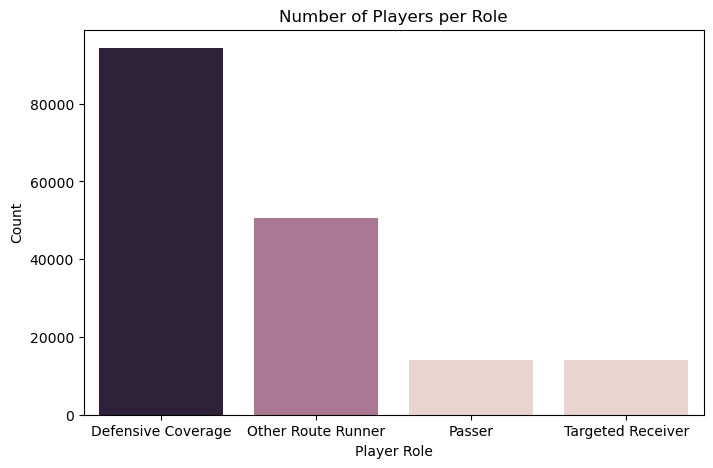

Role counts: 
 Defensive Coverage    94293
Other Route Runner    50644
Passer                14105
Targeted Receiver     14108
dtype: int64


In [416]:
# Characteristics of my data_set
print("Number of rows:", input_df.shape[0])
print("Number of columns:", input_df.shape[1])
print("Number of plays in data set: ", len(input_df['play_id'].unique()))
print("Number players in data set: ", len(input_df['player_name'].unique()))
print("Number of games in data set: ", len(input_df['game_id'].unique()))

# Count missing values
print("Missing values total:", input_df.isna().sum().sum())

roles = ["player_role_Defensive Coverage",
         "player_role_Other Route Runner",
         "player_role_Passer",
         "player_role_Targeted Receiver"]

# Keep only one row per player per play
unique_players = input_df.groupby(["game_id","play_id","nfl_id"])[roles].max().reset_index()

# Sum across all players
role_counts = unique_players[roles].sum()
role_counts.index = [r.replace("player_role_","") for r in role_counts.index]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=role_counts.index, y=role_counts.values, hue=role_counts, legend=False)
plt.title("Number of Players per Role")
plt.ylabel("Count")
plt.xlabel("Player Role")
plt.show()

print("Role counts: \n", role_counts)




Dataset Description

The dataset consists of player-tracking information from 272 NFL games, containing roughly 5 million rows of space/time data. Each row corresponds to a single player at a single frame.
Key variables include:

x, y position (yard coordinates)

s (speed)

a (acceleration)

o, dir (orientation and direction)

player attributes (height, weight, age, position)

play metadata (game_id, play_id, role, side)

ball landing coordinates (for pass plays)

The prediction target is the future 5-frame trajectory of the targeted receiver. We will focus on the targeted receiver in order to predict the movement of the ball reciever of succesful passes. This dataset incldues about 4,000 plays to train a model off of. 

From this data we developed a few research questions, to explore how a players phiscal attributes might impact their route runnign ability. We investigate several questions about player behavior:
1) Do offensive players reach higher maximum speeds than defensive players?
2) Are player heights distributed differently across on-field roles?
3) Does player weight correlate with average speed?
We also tried to see if we could predict where a route would end up based on the direction the QB was facing 
4) Do passers throw in the direction they are facing?

We address these questions using t-tests, ANOVA, Tukey HSD, and correlation analysis.

Hypothesis: Offensive players max speed per play is  statistically signifcantly faster than defensive players
T-statistic: 155.225, Right-tailed p-value: 0.00000e+00


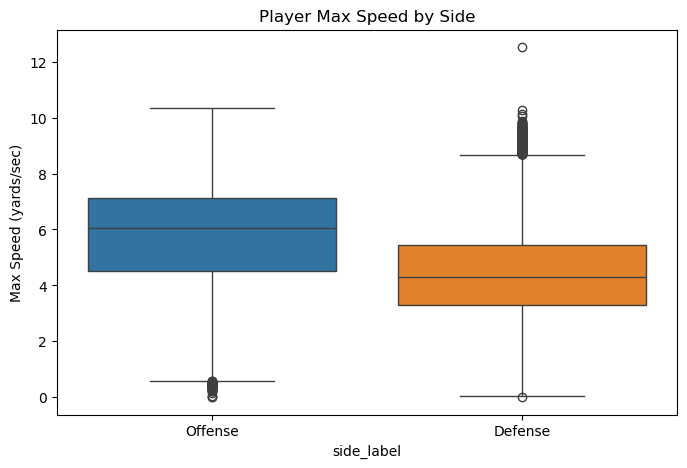

In [417]:
print("Hypothesis: Offensive players max speed per play is  statistically signifcantly faster than defensive players")

max_s = input_df.groupby(["game_id","play_id","nfl_id"])[["s","player_side_Defense","player_side_Offense"]].max().reset_index()

defense_s = max_s.loc[max_s["player_side_Defense"]==1, "s"].dropna()
offense_s = max_s.loc[max_s["player_side_Offense"]==1, "s"].dropna()

t_stat, p_two_tailed = ttest_ind(offense_s, defense_s, equal_var=False)  # offense first
p_right = p_two_tailed / 2 if t_stat > 0 else 1 - p_two_tailed / 2

print(f"T-statistic: {t_stat:.3f}, Right-tailed p-value: {p_right:.5e}")

max_s["side_label"] = ""
max_s.loc[max_s["player_side_Defense"]==1, "side_label"] = "Defense"
max_s.loc[max_s["player_side_Offense"]==1, "side_label"] = "Offense"

plt.figure(figsize=(8,5))
sns.boxplot(x="side_label", y="s", data=max_s, hue="side_label", legend=False)
plt.ylabel("Max Speed (yards/sec)")
plt.title("Player Max Speed by Side")
plt.show()




From the right tailed T statistic we can reject the null hypothesis that offensive players are not statistically significantly, faster than defensive players. From this we can see that there is a correlation between offensive players being faster than defensive. This might suggest that go routes, or routes where an offensive player tries to just run past the defense is an effective strategy and would be represented by seeing many single direction, low movement, routes in our data set

F-statistic: 124121.548, p-value: 0.00000e+00
Tukey HSD results (height by role):
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1             group2       meandiff p-adj lower   upper  reject
--------------------------------------------------------------------------
Defensive Coverage Other Route Runner   0.8469   0.0 0.8411  0.8527   True
Defensive Coverage             Passer   1.9771   0.0 1.9676  1.9866   True
Defensive Coverage  Targeted Receiver   0.8806   0.0 0.8711  0.8901   True
Other Route Runner             Passer   1.1302   0.0 1.1201  1.1402   True
Other Route Runner  Targeted Receiver   0.0337   0.0 0.0237  0.0438   True
            Passer  Targeted Receiver  -1.0964   0.0 -1.109 -1.0839   True
--------------------------------------------------------------------------


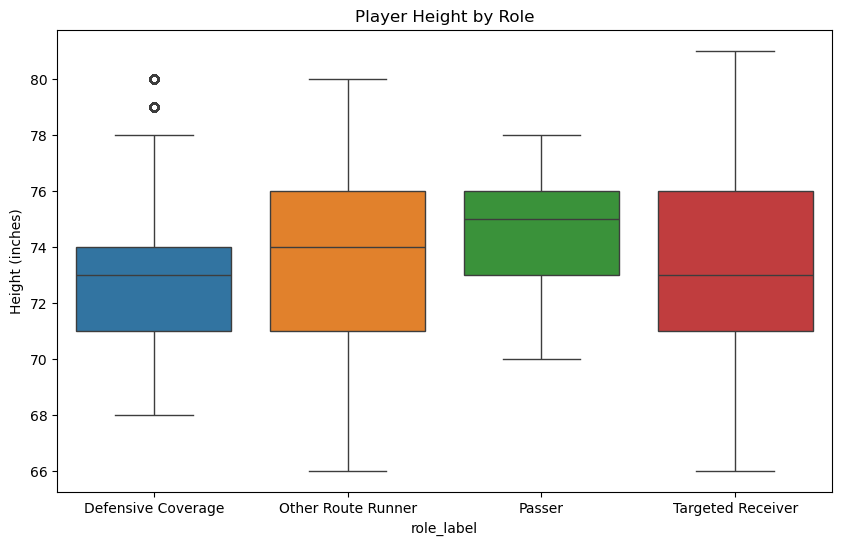

In [418]:

# Roles (already one-hot encoded)
roles = ["Defensive Coverage", "Other Route Runner", "Passer", "Targeted Receiver"]

# Prepare groups for ANOVA
groups = []
for role in roles:
    mask = input_df[f"player_role_{role}"] == 1
    groups.append(input_df.loc[mask, "player_height"].dropna())

# ANOVA test
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.3f}, p-value: {p_val:.5e}")
tukey_df = pd.DataFrame()
tukey_df["player_height"] = pd.concat(
    [input_df.loc[input_df[f"player_role_{role}"]==1, "player_height"] for role in roles],
    ignore_index=True  
)
tukey_df["role"] = pd.concat(
    [pd.Series([role]*input_df.loc[input_df[f"player_role_{role}"]==1, "player_height"].shape[0]) for role in roles],
    ignore_index=True
)
tukey_result = pairwise_tukeyhsd(endog=tukey_df["player_height"], groups=tukey_df["role"], alpha=0.05)
print("Tukey HSD results (height by role):")
print(tukey_result.summary())

# Boxplot by role
# Create a "role_label" column for plotting
input_df["role_label"] = ""
for role in roles:
    input_df.loc[input_df[f"player_role_{role}"]==1, "role_label"] = role

plt.figure(figsize=(10,6))
sns.boxplot(x="role_label", y="player_height", data=input_df, hue="role_label")
plt.xticks()
plt.ylabel("Height (inches)")
plt.title("Player Height by Role")
plt.show()



From the ANova test we can tell reject the null hypothesis for two at least two of the groups as the p value is < .05. Using the Turkey HSD results we can see that we can reject the null hypothesis for all combinations of roles. In particular one that is interesting is that the Targeted reciever is statistically significantly taller than the defensive coverage.

This could suggest that primary route runners do not neccesarily have to actually beat their defensive coutner part as they are likely to catch the ball over their defensier opponent due to their height advantage. However the small variation in ehhigth averages of about .8 inches might not be enough to be relevant to the way targetted recievers would try to run their routes. For taller players, like those above 80 inches this might be significant when runnign against significantly samller players. 

In [419]:
input_df.drop(columns=['role_label'], inplace=True)
input_df.head()
output_df['ball_land_x'] = output_df['x']
output_df['ball_land_y'] = output_df['y']

Pearson correlation: -0.715, p-value: 6.53481e-25


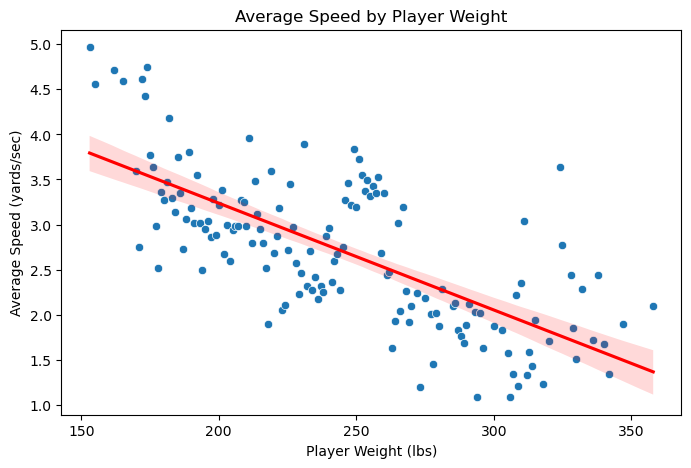

In [420]:
# Hpothesis, Player weight correlates with average speed

agg_df = input_df.groupby("player_weight")["s"].mean().reset_index()
agg_df.rename(columns={"s": "avg_speed"}, inplace=True)

corr, p_val = pearsonr(agg_df["player_weight"], agg_df["avg_speed"])
print(f"Pearson correlation: {corr:.3f}, p-value: {p_val:.5e}")
plt.figure(figsize=(8,5))
sns.scatterplot(x="player_weight", y="avg_speed", data=agg_df)
sns.regplot(x="player_weight", y="avg_speed", data=agg_df, scatter=False, color="red")
plt.xlabel("Player Weight (lbs)")
plt.ylabel("Average Speed (yards/sec)")
plt.title("Average Speed by Player Weight")
plt.show()


From the Pearson correlation p-value which is less than .05 we can conclude reject the null hypothesis that there is no correlation between height and weight. From the slope of the line we can see that lighter players are statistically faster than heavier ones.

This correlation is one of the most important that we have found yet. This correlation stronly suggests that we can partially predict the speed that a route will be based on the weight of a player. This data suggests that the characteristics of the player have an impact on the route running ability, and possibly the type of route the player will run

One-sample t-test:
t-statistic = -11.874, p-value = 2.2999e-32


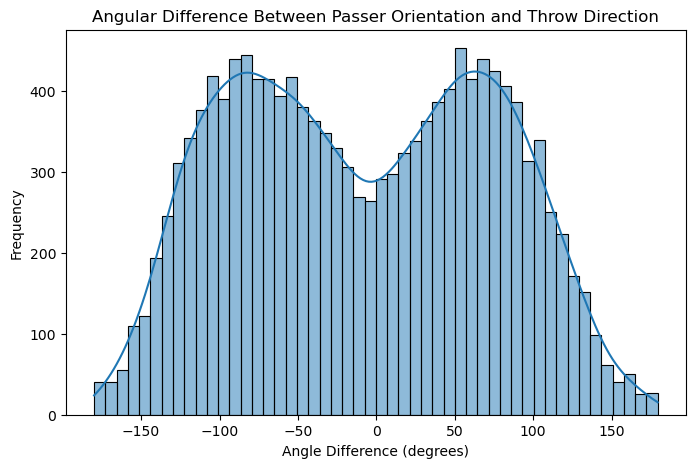

In [421]:

# Hypothesis: Passer orientation correlates with throw direction, we will do 0 degrees is the way the passers hips are facing
passers = input_df.loc[input_df["player_role_Passer"] == 1].copy()

passer_last = (passers.sort_values(["game_id", "play_id", "frame_id"]).groupby(["game_id", "play_id"]).tail(1).reset_index(drop=True))
passer_last = passer_last[["game_id", "play_id", "x", "y", "o", "ball_land_x", "ball_land_y"]].rename(columns={"x": "x_throw", "y": "y_throw", "o": "o_passer"})

passer_last["dx"] = passer_last["ball_land_x"] - passer_last["x_throw"]
passer_last["dy"] = passer_last["ball_land_y"] - passer_last["y_throw"]
passer_last["throw_angle_abs"] = np.degrees(np.arctan2(passer_last["dy"], passer_last["dx"])) % 360 
passer_last["angle_diff"] = ((passer_last["throw_angle_abs"] - passer_last["o_passer"] - 70) % 360) - 180

# we subtract the 70 as the passer generally is pointing 70 degrees off of the way they are throwing straight/looking

angle_diff = passer_last["angle_diff"].values
t_stat, p_val = ttest_1samp(angle_diff, 0)
print(f"One-sample t-test:")
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.4e}")

plt.figure(figsize=(8,5))
sns.histplot(passer_last["angle_diff"], bins=50, kde=True)
plt.title("Angular Difference Between Passer Orientation and Throw Direction")
plt.xlabel("Angle Difference (degrees)")
plt.ylabel("Frequency")
plt.show()


From this one sampled t test we can see that the passer statistically significantly throws away from the direction he is facing. Additionally from looking at the histogram and the line of best fit we can see that in general the passer passes in two distinct zones to the right and left of the way he is facing (generally downfield). 

From this information we can see that the ball is often passed down the field at an angle of about 0-100 degrrees on each side with most balls ending up around the 80 degree mark on each side. This suggests that the most common routes are relatively short, stretching about 10m from the location of the start of the play, and routes that go directly laterally from the QB are much less common, with passes going backwards almost never happening. This should be captured in our predictions for the routes as most routes should end up in these locations

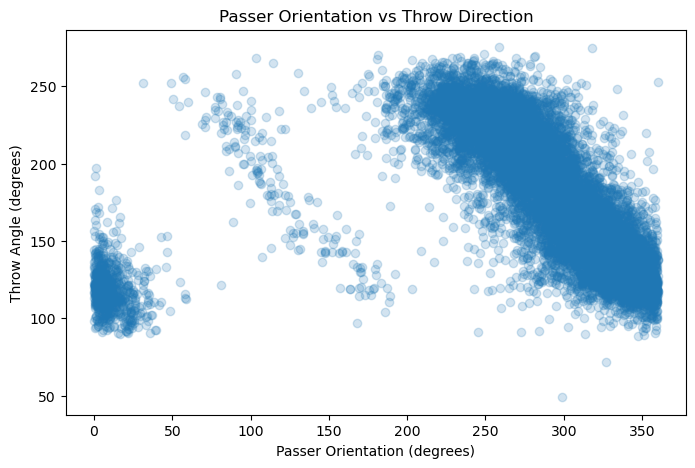

In [422]:
plt.figure(figsize=(8,5))
plt.scatter(passer_last["o_passer"], passer_last["throw_angle_abs"], alpha=0.2)
plt.xlabel("Passer Orientation (degrees)")
plt.ylabel("Throw Angle (degrees)")
plt.title("Passer Orientation vs Throw Direction")
plt.show()

Looking at our data we can see that it is a well crafted data set with nearly 5 million different points of data. The data set represents more than 4,000 different plays that happened in the nfl from a set of 272 games. There is no missing data in the set to encode but there are some interesting facts. Overall the dataset is set up to allow someone to predict how the targeted receiver will move as the ball is in the air. In the dataset there is a surplus of players in the defensive coverage role, which makes sense as the amount of runners, including the targeting receiver, and the passer will generally be equal to or less than those on the defensive side of the ball. This means that there are more entries for the defense than all the other three roles combined. Looking further into the data we can make some interesting observations about the correlation of attributes for the players. When examining the max speed on a play by the defense and the offense we can see that the offense is statistically significantly faster than the defense. This could be for a couple reasons, including that the defense will start closer to the eventual position of the ball, while the offense's role often is to get past the defense. Another interesting fact is that every single role is statistically significantly different in their heights. This is interesting because it would suggest that players' roles could be determined by their height or that certain heights are better suited to certain roles. Lastly, one of the most interesting conclusions drawn from this data is that the angle thrown by the passer, most often the QB, is statistically significantly different from the angle they are facing with their lead foot. This would suggest, as most QBs look to throw downfield from the center position, that QBs statistically significantly target either side of the field rather than the middle which could be useful when trying to predict how route runners will finish their routes.

Now we will try to predict the designated recievers route based on all the data collected for the route ie x,y positon acceleration, velocity in the previous frames as well as the attributes of the player. We will try to do this using a neural network. However we can not just use a normal feed forward neural network as the neural network will not recognize that the sequences of frames are in order and matter. Therefore we will use an LSTM. An LSTM Long Short Term Memory Network allows us to forcast our future trajectory based on the previous time steps as well.

In [423]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
#convention 

HISTORY = 8        
HORIZON = 5 # goal is to predict the future 5 positions based on the past 8 positions
DT = 0.1 # seconds per frame accordign to kaggle
BATCH_SIZE = 64
LSTM_EPOCHS = 10
LSTM_LR = 1e-3
# goal is to predict the future 5 positions based on the past 8 positions

In [424]:
role_cols = [c for c in input_df.columns if c.startswith("player_role_")]
side_cols = [c for c in input_df.columns if c.startswith("player_side_")]

BASE_POSITION = ["x", "y"]
MOTION = ["s", "a", "o"]
PLAYER_ATTRS = ["player_height", "player_weight", "player_age"]

FEATURE_COLS = BASE_POSITION + MOTION + role_cols + side_cols + PLAYER_ATTRS
FEATURE_COLS


['x',
 'y',
 's',
 'a',
 'o',
 'player_role_Defensive Coverage',
 'player_role_Other Route Runner',
 'player_role_Passer',
 'player_role_Targeted Receiver',
 'player_side_Defense',
 'player_side_Offense',
 'player_height',
 'player_weight',
 'player_age']

Here we are labeling the different data into important groups. Base position is the past data of the two categories we want to predict. Motion is all the data to do with the motion of the player. Player Attributes has to do with the players physical attributes. These are all our feature Cols

In [425]:
def build_sequences(df, history=HISTORY, horizon=HORIZON):
    X_seqs = [] # this is the input sequence, the past positions of length history
    Y_seqs = [] # this is the output sequence, the future positions of length horizon
    meta = [] #meta data for each seqeunce game_id, play_id, nfl_id

    grouped = df.groupby(["game_id", "play_id", "nfl_id"])

    for (gid, pid, nid), g in grouped:
        g = g.sort_values("frame_id").reset_index(drop=True)

        if "player_role_Targeted Receiver" in g.columns:
            if g["player_role_Targeted Receiver"].sum() == 0: # we only want targeted receivers
                continue

        T = len(g)
        if T < history + horizon:
            continue

        feats = g[FEATURE_COLS].values.astype(np.float32)
        positions = g[["x", "y"]].values.astype(np.float32)

        for t in range(T - (history + horizon)):
            X_seqs.append(feats[t:t+history])
            Y_seqs.append(positions[t+history:t+history+horizon])
            meta.append((gid, pid, nid))

    return np.array(X_seqs), np.array(Y_seqs), meta

X, Y, meta = build_sequences(input_df)
X.shape, Y.shape


((213657, 8, 14), (213657, 5, 2))

In [426]:
meta_keys = [f"{g}_{p}" for g,p,_ in meta]
meta_keys = np.array(meta_keys) # we are creating a unique key for each play based on game and play id

unique_plays = np.unique(meta_keys)
train_plays, test_plays = train_test_split(unique_plays, test_size=0.2, random_state=SEED) # we are randomly splitting into a train and test set, we can do this without kfold as we have a lot of play data

train_mask = np.isin(meta_keys, train_plays) # just masks for train and test plays to split data
test_mask = np.isin(meta_keys, test_plays)

X_train_full = X[train_mask]
Y_train_full = Y[train_mask]
X_test = X[test_mask]
Y_test = Y[test_mask]

# this gives our full data split from whcih we can create a validation set

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, test_size=0.2, random_state=SEED
)

X_train.shape, X_val.shape, X_test.shape


((136625, 8, 14), (34157, 8, 14), (42875, 8, 14))

In [427]:
def ade(y_true, y_pred):
    d = np.linalg.norm(y_true - y_pred, axis=-1)
    return d.mean()

def fde(y_true, y_pred):
    d = np.linalg.norm(
        y_true[:, -1, :] - y_pred[:, -1, :], axis=-1
    )
    return d.mean()


# these are the evaluation metrics we will use

These evaluation metrics are extremely important and tell us three different things. ADE tells us the average distance between the predicted and true points, fde tells us the final point in the sequence from the true. We can use ADE as a metric to see if the physics of our model is accurate and as a basic metric to see how the model is doing, while FDE tells us if we are correctly interperating the ending of the run which is the most important part of a route to predict. Two models with similar ADE with the second having a significantly better FDE, will be unequal models with the second being much better.

In [428]:
# Flatten sequences for linear models
def flatten(X):
    N, H, F = X.shape
    return X.reshape(N, H*F)

Xtr = flatten(X_train)
Xva = flatten(X_val)

Ytr = Y_train.reshape(len(Y_train), -1)
Yva = Y_val.reshape(len(Y_val), -1)

lr = LinearRegression()
lr.fit(Xtr, Ytr)

pred_lr = lr.predict(Xva).reshape(Y_val.shape)

y_true = Y_val     
y_pred = pred_lr     

print("LR ADE:", ade(Y_val, pred_lr))
print("LR FDE:", fde(Y_val, pred_lr))




LR ADE: 1.7239828
LR FDE: 2.3629916


Our baseline test will be to use linear regression which does not make sense for the time series data but we will provide a test for our plotting, input data, and a baseline for our evaluation metrics


In [429]:
def plot_full_trajectory_ax(ax, X_history, y_true, y_pred, idx=0):
    hist_xy = X_history[idx][:, :2]
    true_xy = y_true[idx]
    pred_xy = y_pred[idx]

    ax.plot(hist_xy[:,0], hist_xy[:,1], 'ko-', label='History')
    ax.plot(true_xy[:,0], true_xy[:,1], 'bo-', label='True Future')
    ax.plot(pred_xy[:,0], pred_xy[:,1], 'ro--', label='Predicted Future')

    ax.scatter(true_xy[-1,0], true_xy[-1,1], c='blue', s=40)
    ax.scatter(pred_xy[-1,0], pred_xy[-1,1], c='red', s=40)

    ax.set_title(f"Sample {idx}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)
    ax.invert_yaxis()


This will be our function to plot the position predictions, of the predicted future, as well as showing the route up till the hroizon time. We will plot these using random instances of our validation set to get a diverse sample, ie not from one game. We will also importantly use our evaluation metrics to conirm the visuals

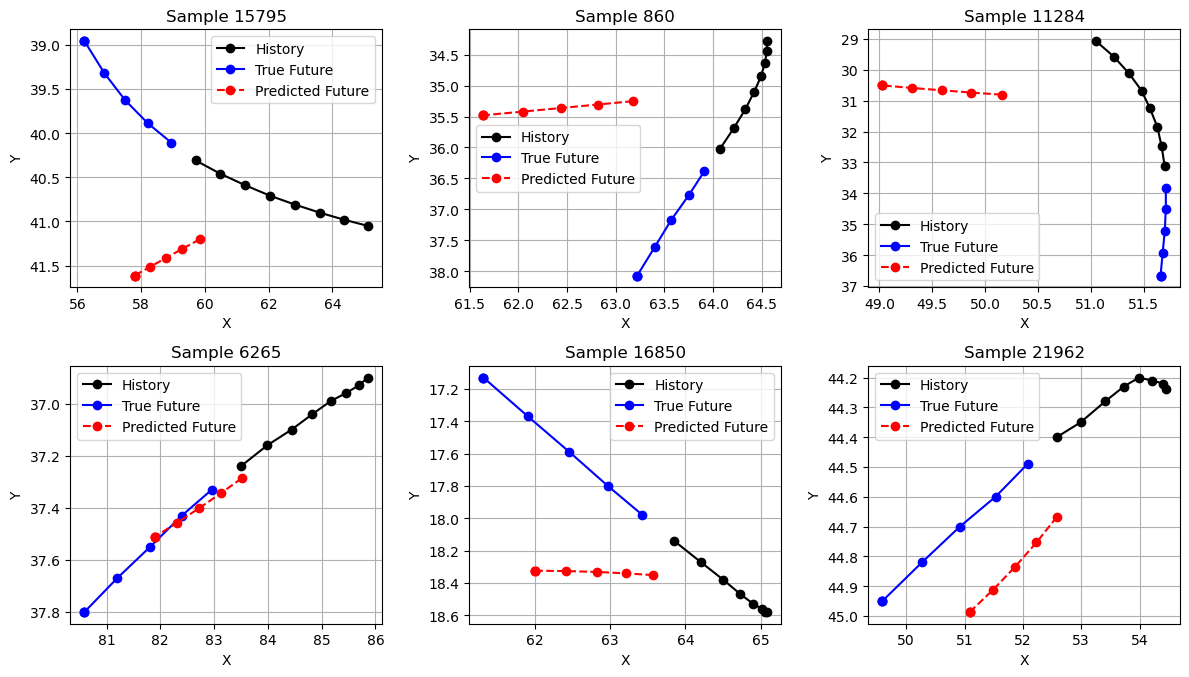

In [430]:


num_samples = 6
plt.figure(figsize=(12, 30))
for j in range(num_samples):
    num = np.random.randint(0, len(X_val) - num_samples + 1)
    ax = plt.subplot(9, 3, j+1)
    plot_full_trajectory_ax(ax, X_val, Y_val, pred_lr, idx=num)
    plt.legend()
plt.tight_layout()
plt.show()




As we can see from the graphs as well as luation metrics, we can see that the predcitions for the route are inaacurate and do not make physical sense, this is one of the key features we will want to consider when creating our final ML solution as we want the route predictions to make sense in the real world. A route prediction that has a player teleporting a yard or two will always be impossible.

In [431]:

class TrajectoryDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]



In [432]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, horizon=5):
        super().__init__()
        self.horizon = horizon
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, horizon * 2) # predict x,y for each future step
        )

    def forward(self, x):
        _, (h_last, _) = self.lstm(x)
        h = h_last[-1] # final layer hidden state
        out = self.decoder(h)
        return out.view(-1, self.horizon, 2)


In [433]:
input_dim = X_train.shape[-1]
model = LSTMForecaster(input_dim=input_dim, hidden_dim=128).to("cpu")

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_ds = TrajectoryDataset(X_train, Y_train)
val_ds = TrajectoryDataset(X_val, Y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [434]:
# Training loop with velocity and position loss to mdoel physics
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_train = 0
    for Xb, Yb in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        pred = model(Xb)

        v_pred = pred[:, 1:, :] - pred[:, :-1, :]
        v_true = Yb[:, 1:, :] - Yb[:, :-1, :]
        vel_loss = loss_fn(v_pred, v_true)

        pos_loss = loss_fn(pred, Yb)
        lambda_vel = 0.1
        loss = pos_loss + lambda_vel * vel_loss   
             
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_train += loss.item() * Xb.size(0)
    train_loss = total_train / len(train_ds)

    model.eval()
    total_val = 0
    with torch.no_grad():
        for Xb, Yb in val_loader:
            pred = model(Xb)
            total_val += loss_fn(pred, Yb).item() * Xb.size(0)
    val_loss = total_val / len(val_ds)

    print(f"Epoch {epoch+1}/{EPOCHS}  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")


Epoch 1/10  Train Loss: 66.6654  Val Loss: 2.4339


Epoch 2/10  Train Loss: 1.7590  Val Loss: 1.3358


Epoch 3/10  Train Loss: 1.3763  Val Loss: 1.4649


Epoch 4/10  Train Loss: 1.1320  Val Loss: 0.9948


Epoch 5/10  Train Loss: 0.8332  Val Loss: 0.4710


Epoch 6/10  Train Loss: 0.7686  Val Loss: 2.2729


Epoch 7/10  Train Loss: 0.7257  Val Loss: 0.2039


Epoch 8/10  Train Loss: 0.6496  Val Loss: 0.3844


Epoch 9/10  Train Loss: 0.6073  Val Loss: 0.3810


Epoch 10/10  Train Loss: 0.5599  Val Loss: 0.1481


In [435]:
pred_nn = model(torch.tensor(X_val)).detach().numpy()

print("LSTM ADE:", ade(Y_val, pred_nn))
print("LSTM FDE:", fde(Y_val, pred_nn))



LSTM ADE: 0.47194603
LSTM FDE: 0.62549263


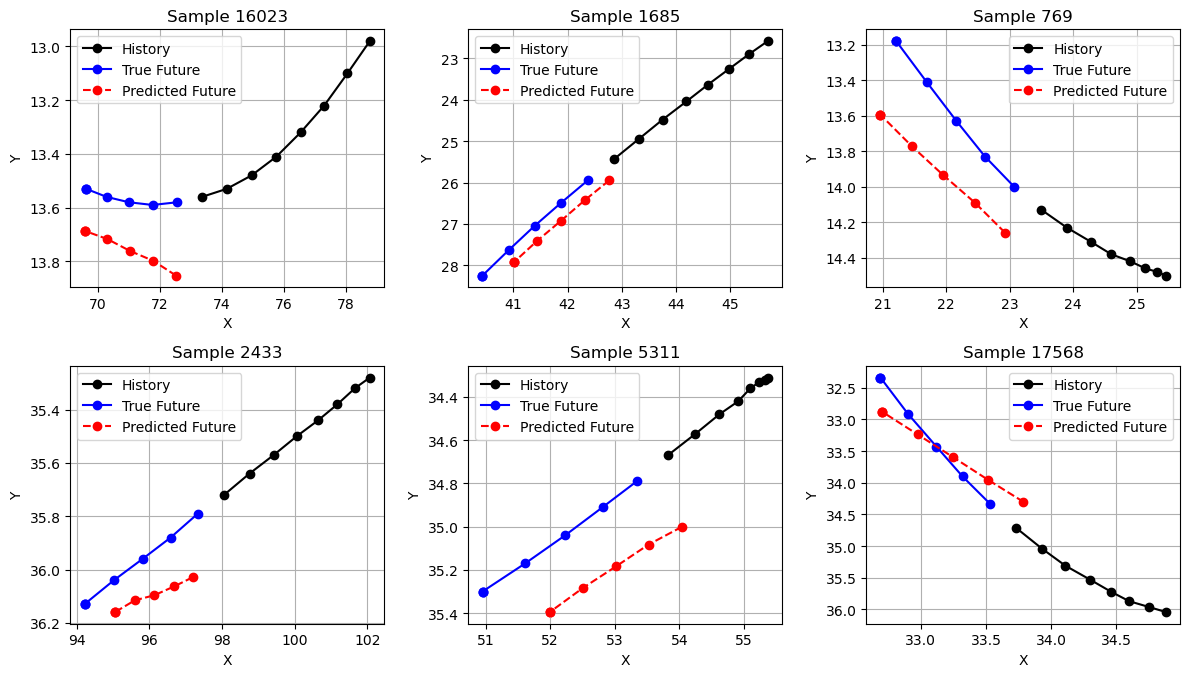

In [436]:


num_samples = 6
plt.figure(figsize=(12, 30))
for j in range(num_samples):
    num = np.random.randint(0, len(X_val) - num_samples + 1)
    ax = plt.subplot(9, 3, j+1)
    plot_full_trajectory_ax(ax, X_val, Y_val, pred_nn, idx=num)
    plt.legend()
plt.tight_layout()
plt.show()



As we can see these results are significantly better than the Linear fit which does not take into account the time series of the data. The result shows an average displacment error of .47 yards which is significantly better than the lienar fit of 1.7 yards. importantly the FDE is also significantly better indicating the fit is not consistantly moving away from the predicted route. However when we actually plot tehse graphs we can see that the physics still often do not make sense with players having to teleprot to the beginning of the post horizon routes. Additionally the routes often do not reflect the true routes direction at all and seem somewhat random. Clearly we need a better method of predicting player movement and incorporate this into our model.

The model we will try next is a Kalman Filter based approach. This is not a ML tactic that was discussed in CMSC320 however it was a significant portion of another class I took which is CMSC421 intro to AI. Kalman filters use previous positioning and velocity to predict the future movement of an object. In this case we will try to use the Kalman filter aproach to create a baseline for movement and later see if a neural network can use this baseline plus the other features to improve on the baseline. 

In [437]:
class KalmanFilterCV:
    def __init__(self, dt=0.1, Q_scale=0.05, R_scale=0.2, P0=1.0):
        self.dt = dt
        self.A = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1,  0],
            [0, 0, 0,  1]
        ])
        self.H = np.array([[1,0,0,0],[0,1,0,0]])
        self.Q = np.eye(4) * Q_scale
        self.R = np.eye(2) * R_scale
        self.P = np.eye(4) * P0
        self.x = np.zeros((4,1))

    def initialize(self, x, y, vx, vy, P0=1.0):
        self.x = np.array([[x],[y],[vx],[vy]], dtype=float)
        self.P = np.eye(4) * P0

    def predict(self):
        self.x = self.A @ self.x
        self.P = self.A @ self.P @ self.A.T + self.Q
        return self.x[:2].flatten()

    def update(self, meas):
        z = np.array(meas).reshape(2,1)
        y = z - (self.H @ self.x)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P

def kf_predict_one(X_seq, FEATURE_COLS, horizon=5, dt=0.1):
    name2i = {n:i for i,n in enumerate(FEATURE_COLS)}

    xs = X_seq[:, name2i["x"]].astype(float)
    ys = X_seq[:, name2i["y"]].astype(float)

    # estimate velocity from last two points
    vx = 1.5*(xs[-1] - xs[-2]) / dt
    vy = 1.5*(ys[-1] - ys[-2]) / dt

    kf = KalmanFilterCV(dt=dt)
    kf.initialize(xs[-1], ys[-1], vx, vy)

    # feed history (predict -> update)
    for i in range(len(xs)):
        kf.predict()
        kf.update([xs[i], ys[i]])

    preds = []
    for _ in range(horizon):
        preds.append(kf.predict())

    return np.array(preds)

def run_kf(X_val, Y_val, FEATURE_COLS, n_show=6):
    preds = np.zeros_like(Y_val)
    N = len(X_val)
    for i in range(N):
        preds[i] = kf_predict_one(X_val[i], FEATURE_COLS)


    return preds


In [438]:
preds_kf = run_kf(X_val, Y_val, FEATURE_COLS, n_show=6)
print("Kalman ADE:", ade(Y_val, preds_kf))
print("Kalman FDE:", fde(Y_val, preds_kf))


Kalman ADE: 0.36763173
Kalman FDE: 0.6684084


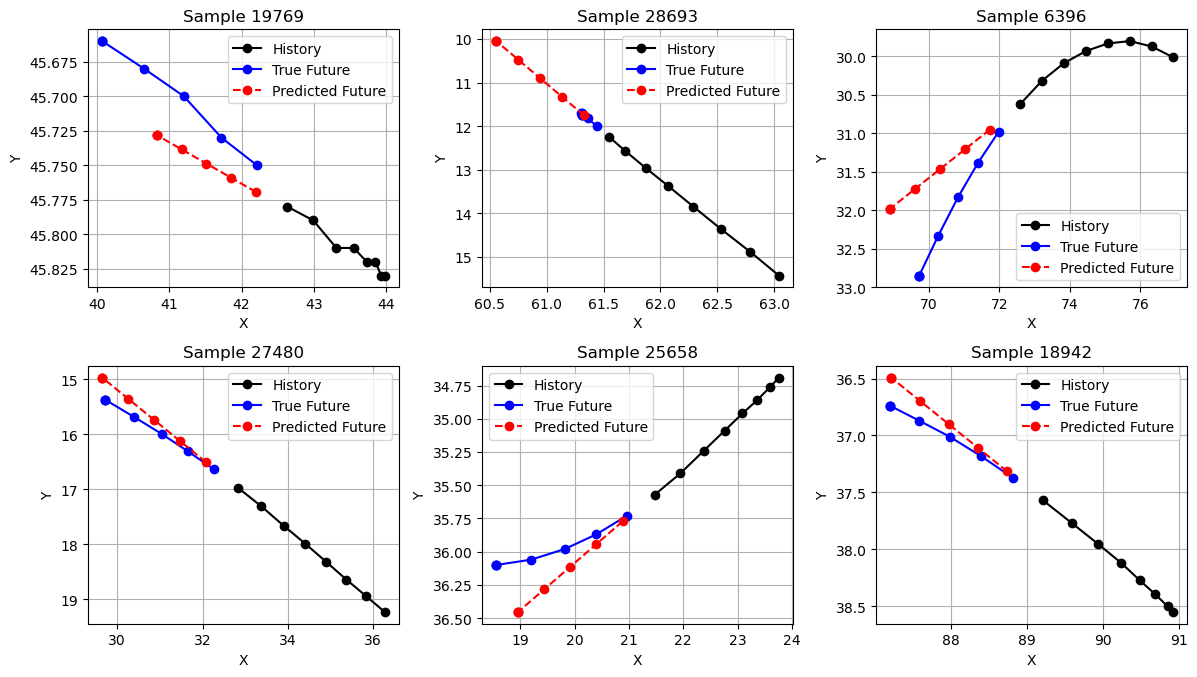

In [439]:


num_samples = 6
plt.figure(figsize=(12, 30))
for j in range(num_samples):
    num = np.random.randint(0, len(X_val) - num_samples + 1)
    ax = plt.subplot(9, 3, j+1)
    plot_full_trajectory_ax(ax, X_val, Y_val, preds_kf, idx=num)
    plt.legend()
plt.tight_layout()
plt.show()



As we can see from the ADE and FDE the Kalman filter is actually quite bad. However looking at the plots we do see that the kalman filter is predicting the direction of linear routes quite well but struggling to model the acceleration that comes after the horizon as well as cuved routes. This could be a good baseline for our neural network but we will first try to just model a polynomial to the data and see if this has can be a better baseline to use.

In [440]:

def fit_quadratic_weighted(t, y, w):

    X = np.vstack([t**2, t, np.ones_like(t)]).T
    W = np.diag(w)  # weight matrix
    # Solve (X^T W X) beta = X^T W y
    A = X.T @ W @ X
    B = X.T @ W @ y
    coeffs = np.linalg.solve(A, B)
    return coeffs  # a,b,c


def poly2_predict_one_biased(X_seq, FEATURE_COLS, horizon=5, dt=0.1, weight_last=1e6):
    name2i = {n:i for i,n in enumerate(FEATURE_COLS)}

    xs = X_seq[:, name2i["x"]].astype(float)
    ys = X_seq[:, name2i["y"]].astype(float)

    n = len(xs)
    t_hist = np.arange(n) * dt
    t_pred = np.arange(n, n+horizon) * dt

    # weights: 1 for all early points, huge for last 2
    w = np.ones(n)
    if n >= 2:
        w[-1] = weight_last
        w[-2] = weight_last

    # Fit x(t)
    ax, bx, cx = fit_quadratic_weighted(t_hist, xs, w)
    # Fit y(t)
    ay, by, cy = fit_quadratic_weighted(t_hist, ys, w)

    # Predict future
    x_pred = ax*t_pred**2 + bx*t_pred + cx
    y_pred = ay*t_pred**2 + by*t_pred + cy

    return np.vstack([x_pred, y_pred]).T


def run_poly2_biased(X_val, Y_val, FEATURE_COLS, horizon=None, n_show=6, dt=0.1, weight_last=1e6):
    if horizon is None:
        horizon = Y_val.shape[1]

    preds = np.zeros_like(Y_val)
    N = len(X_val)

    for i in range(N):
        preds[i] = poly2_predict_one_biased(
            X_val[i], FEATURE_COLS, horizon=horizon, dt=dt, weight_last=weight_last
        )

    return preds


In this polynomial we use a biased polynomial fit, biasing the last two poitns. We do this as the beginning of routes are often less predictive of the ending of the route as early push off directions and positions are often to lose defenders rather than indicitive of where the route will go.

In [441]:
preds_biased = run_poly2_biased(X_val, Y_val, FEATURE_COLS, weight_last=1e6)
print("Poly ADE:", ade(Y_val, preds_biased))
print("Poly FDE:", fde(Y_val, preds_biased))

Poly ADE: 0.14774717
Poly FDE: 0.33605146


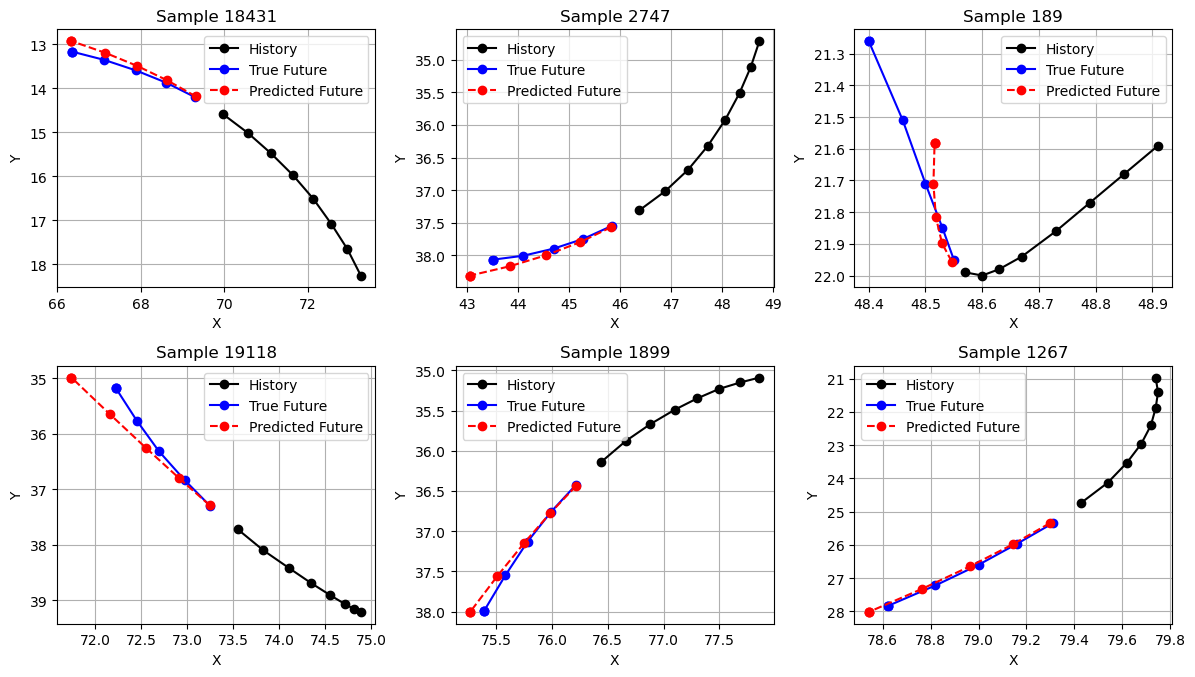

In [442]:


num_samples = 6
plt.figure(figsize=(12, 30))
for j in range(num_samples):
    num = np.random.randint(0, len(X_val) - num_samples + 1)
    ax = plt.subplot(9, 3, j+1)
    plot_full_trajectory_ax(ax, X_val, Y_val, preds_biased, idx=num)
    plt.legend()
plt.tight_layout()
plt.show()



As you can see the ADE and FDE have significantly improved from the Kalman filter, coming down to .14 and .33 respectively. This is an extremely good result and the graphs reflect this too with the predicted and actual routes looking almost identical except for small directionality changes. This is the perfect baseline as it hypothetically allows us to trian a neural network to predict the deviations from the polynomial that come down to player preferecnes possibly due to player characteristics. 

In [443]:
# Compute the polynomial baseline for train and val
poly_train = run_poly2_biased(X_train, Y_train, FEATURE_COLS, weight_last=1e6)
poly_val = run_poly2_biased(X_val, Y_val, FEATURE_COLS, weight_last=1e6)
Y_train_res = Y_train - poly_train
Y_val_res = Y_val - poly_val

In [444]:

class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, horizon=5):
        super().__init__()
        self.horizon = horizon
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, horizon * 2)
        )

    def forward(self, x):
        _, (h_last, _) = self.lstm(x)
        h = h_last[-1]
        out = self.decoder(h)
        return out.view(-1, self.horizon, 2) # predicts RESIDUAL positions, residual is calcualted from the polymoial fit


In [445]:
model = LSTMForecaster(
    input_dim=X_train.shape[-1],
    hidden_dim=128,
    num_layers=2,
    horizon=Y_train.shape[1]
).to("cpu")

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_ds = TrajectoryDataset(X_train, Y_train_res)
val_ds = TrajectoryDataset(X_val, Y_val_res)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


EPOCHS = 10
lambda_vel = 0.1 # claculated through multiple trials

for epoch in range(EPOCHS):
    model.train()
    total_train = 0

    for Xb, Yb_res in tqdm(train_loader, leave=False):
        optimizer.zero_grad()

        pred_res = model(Xb) # residual prediction

        # Position loss
        pos_loss = loss_fn(pred_res, Yb_res)

        # velocity loss
        v_pred = pred_res[:, 1:] - pred_res[:, :-1]
        v_true = Yb_res[:, 1:] - Yb_res[:, :-1]
        vel_loss = loss_fn(v_pred, v_true)

        # total loss, lambda calculated through trial and error
        loss = pos_loss + lambda_vel * vel_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_train += loss.item() * Xb.size(0)

    train_loss = total_train / len(train_ds)

    # validation
    model.eval()
    total_val = 0
    with torch.no_grad():
        for Xb, Yb_res in val_loader:
            pred_res = model(Xb)
            total_val += loss_fn(pred_res, Yb_res).item() * Xb.size(0)

    val_loss = total_val / len(val_ds)
    print(f"Epoch {epoch+1}/{EPOCHS}  Train: {train_loss:.4f}  Val: {val_loss:.4f}")


Epoch 1/10  Train: 0.0175  Val: 0.0165


Epoch 2/10  Train: 0.0156  Val: 0.0146


Epoch 3/10  Train: 0.0148  Val: 0.0139


Epoch 4/10  Train: 0.0143  Val: 0.0139


Epoch 5/10  Train: 0.0140  Val: 0.0139


Epoch 6/10  Train: 0.0137  Val: 0.0130


Epoch 7/10  Train: 0.0133  Val: 0.0135


Epoch 8/10  Train: 0.0129  Val: 0.0129


Epoch 9/10  Train: 0.0125  Val: 0.0120


Epoch 10/10  Train: 0.0122  Val: 0.0126


In [446]:
with torch.no_grad():
    pred_res_val = model(torch.tensor(X_val, dtype=torch.float32)).numpy()

pred_abs = pred_res_val + poly_val   # final predictions

print("NN ADE:", ade(Y_val, pred_abs))
print("NN FDE:", fde(Y_val, pred_abs))


NN ADE: 0.10855695
NN FDE: 0.24015684


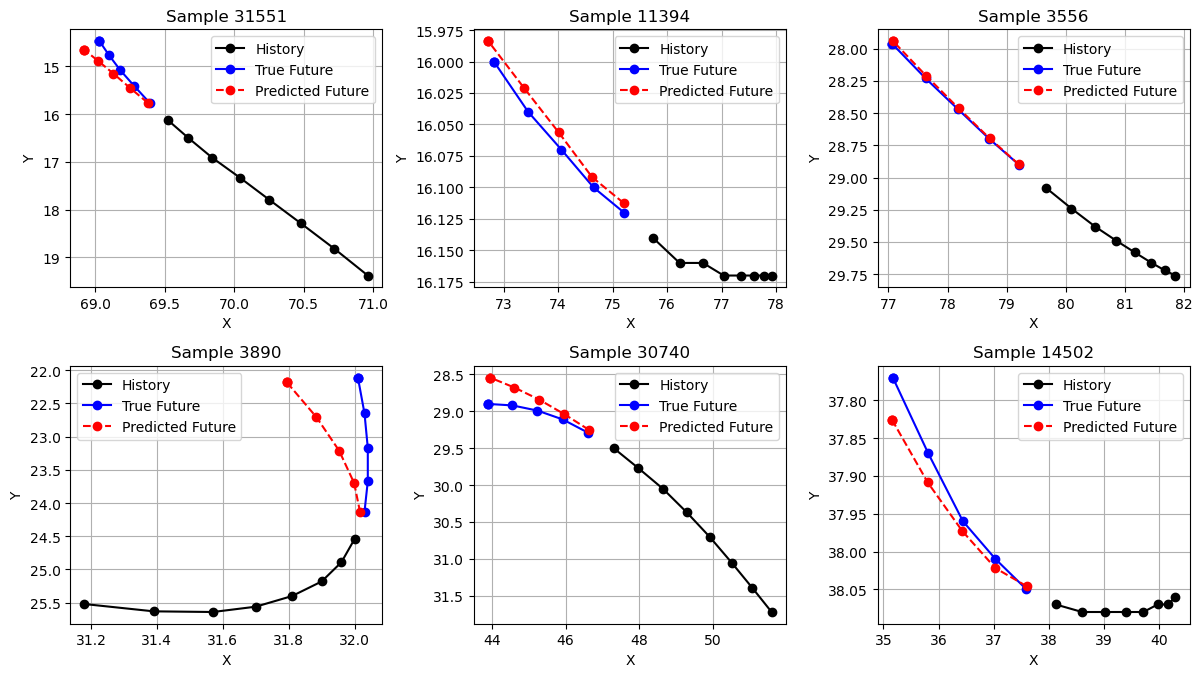

In [447]:


num_samples = 6
plt.figure(figsize=(12, 30))
for j in range(num_samples):
    num = np.random.randint(0, len(X_val) - num_samples + 1)
    ax = plt.subplot(9, 3, j+1)
    plot_full_trajectory_ax(ax, X_val, Y_val, pred_abs, idx=num)
    plt.legend()
plt.tight_layout()
plt.show()



As we can see from the results of our neural network the ADE and FDE have improved from the polynomial fit. This suggests that our hypothesis was correct and that route runs are effected by players characteristics and can be further predicted beyond initial route shape by the player who is running them. This observation is hugely significant for an NFL team as it is known before hnad the types of routes that are available as well as which players will be running on the day. Doing deep data analysis that is beyond the scope of this project could allow teams to model individual players route tendencies and predict how they will end their routes giving a possibly significant advantage to nfl teams. To the Lay person this already seems significant but at a higher level of football small details in how a route will finish are extremely important. How a route finishes allows defensive players to get inside leverage leading to an increase in picks and incompletge passes. Additionally offensive players, who by their own teams data have obvious route tendencies, can start to vary route endings to become less predictable for defenders